# Preliminaries

In [ ]:
%pip install einops
import os
import pandas as pd
from google.colab import drive
from pathlib import Path
from numpy.random import randint
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
  

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# Custom Dataset class

In [ ]:
class imuDataset(Dataset):
    def __init__(self, dataDir,xCols, yCols, windowSize = 512, transform=None, target_transform=None):
        # Inputs:
        #   - dataDir: list of directories with data files
        #   - xCols: list of input variable names
        #   - yCols: list of target variable names
        #   - windowSize: length in samples for time window of training sequence
        #                 if == -1, use whole seqence (validation, testing)
        self.xCols = xCols
        self.yCols = yCols
        self.dataDir = dataDir
        self.windowSize = windowSize
        self.transform = transform
        self.target_transform = target_transform
        self.files = dataDir
        # pre-load all files
        dataSets = []
        for file in dataDir:
            samp_path = file
            # load the file
            dat = pd.read_csv(samp_path, index_col='Unnamed: 0')            
            dataSets.append(dat)
        self.dataSets = dataSets

    def set_windowSize(self, windowSize):
        self.windowSize = windowSize

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # get the file
        dat = self.dataSets[idx]
        # get random window in file
        if self.windowSize != -1:
            starti = np.random.randint(0,dat.shape[0] - self.windowSize)
            endi = starti + self.windowSize
            dat = dat.iloc[starti:endi]
        #select variables
        x = dat[self.xCols].values
        y = dat[self.yCols].values
        # do optional transforms
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        if idx == self.__len__():
            raise IndexError     
        return x, y

# Define filepaths, inputs, targets

In [ ]:
# set root data directory
base_path = '/content/drive/MyDrive/Neuromatch/'
fig_path = base_path + 'figs/'
out_path = base_path + 'preproc/'
# list of file paths
files = [str(file) for file in list(Path(out_path).glob('*'))]

# input is orientation and acceleration from right forearm
input = ['RightForeArm_rot_0',
         'RightForeArm_rot_1',
         'RightForeArm_rot_2',
         'RightForeArm_rot_3',
         'RightForeArm_rot_4',
         'RightForeArm_rot_5',
         'RightForeArm_rot_6',
         'RightForeArm_rot_7',
         'RightForeArm_rot_8',   
         'RightForeArm_acc_0',
         'RightForeArm_acc_1',
         'RightForeArm_acc_2',]

# output:
# 0:2 - reconstruct input accelerations
# 3:  - first two cols of 3x3 rotation matrices for orientations 
#       of target body segments
output =    ['RightForeArm_acc_0',
            'RightForeArm_acc_1',
            'RightForeArm_acc_2',
             
            'RightShoulder_rot_0',
            'RightShoulder_rot_1',
            #'RightShoulder_rot_2',
            'RightShoulder_rot_3',
            'RightShoulder_rot_4',
            #'RightShoulder_rot_5',
            'RightShoulder_rot_6',
            'RightShoulder_rot_7',
            #'RightShoulder_rot_8',

            'RightArm_rot_0',
            'RightArm_rot_1',
            #'RightArm_rot_2',
            'RightArm_rot_3',
            'RightArm_rot_4',
            #'RightArm_rot_5',
            'RightArm_rot_6',
            'RightArm_rot_7',
            #'RightArm_rot_8',

            'RightHand_rot_0',
            'RightHand_rot_1',
            #'RightHand_rot_2',
            'RightHand_rot_3',
            'RightHand_rot_4',
            #'RightHand_rot_5',
            'RightHand_rot_6',
            'RightHand_rot_7']
            #'RightHand_rot_8']

# define model

*   dense > relu > LSTM > dense 
*   bidirectional LSTM with 2 layers
*   dropout on inputs






In [ ]:
# initialize models

#bidirectional LSTM
class biLSTM(nn.Module):
  def __init__(self, output_size, input_size , hidden_size1,
               hidden_size2, device):
    super(biLSTM, self).__init__()
    self.output_size = output_size
    self.input_size = input_size
    self.hidden_size1 = hidden_size1 # fully connected layer 1 width
    self.hidden_size2 = hidden_size2 # LSTM layers width
    self.device = device 
    # Define the dropout layer
    self.dropout = nn.Dropout(0.2)
    # Define the fully connected input
    self.fc1 = nn.Linear(input_size, hidden_size1, device=device)
    # Define the bilstm layer
    self.bilstm = nn.LSTM(hidden_size1, hidden_size2, num_layers=2, bidirectional=True)
    # Define the fully-connected output layer
    self.fc2 = nn.Linear(2*hidden_size2, output_size, device=device)

  def forward(self, input):
    x = self.dropout(input)
    x = self.fc1(x).permute(1, 0, 2)
    x = F.relu(x)
    # initialize hidden and memory states
    hidden = (torch.zeros(4, x.shape[1], self.hidden_size2).double().to(self.device),
              torch.zeros(4, x.shape[1], self.hidden_size2).double().to(self.device))
    # run LSTM and FC2
    output_rnn, hidden = self.bilstm(x, hidden)
    output = self.fc2(output_rnn.permute(1,0,2))

    # first three elements of output are reconstruction of acceleration
    # the rest are for 6 dof orientation representation
    # below: performs the gram-schmidt process on the orientation outputs
    #        to get first 2 cols of orthonormal rotation matrix
    
    # set aside acceleration outputs
    output_acc = output[:,:,0:3]
    # get rotation outputs
    output_rot = output[:,:,3:]
    # store original shape of rotation outputs
    shape0 = output_rot.shape 
    #reshape for algebra > (batch*time*joints X rows X cols)
    output_rot = rearrange(output_rot, 'b t (j r c) -> (b t j) r c',j=3, r=3)
    
    # do gram schmidt process batchwise to constrain rotation matrices to be orthonormal
    v1 = torch.unsqueeze(output_rot[:,:,0], dim=2)
    v2 = torch.unsqueeze(output_rot[:,:,1], dim=2)
    c1 = F.normalize(v1,dim=1) 
    u2 = v2 - torch.bmm(c1.permute(0,2,1), v2) * c1
    c2 = F.normalize(u2,dim=1) 
    output_rot = torch.cat((c1,c2), dim = 2)

    ## unflatten into batchsize x timepoints x joints(3) x 3 x 2
    output_rot = rearrange(output_rot, '(b t j) r c -> b t (j r c)',b=shape0[0], t=shape0[1], j=3, r=3, c=2)

    # concatenate acceleration and orthonormalized rotations
    return torch.cat((output_acc, output_rot), dim = 2)

# MLP
class mlp(nn.Module):
  def __init__(self, output_size, input_size , hidden_size1,
               hidden_size2, device):
    super(mlp, self).__init__()
    self.output_size = output_size
    self.input_size = input_size
    self.hidden_size1 = hidden_size1 # layer 1 width
    self.hidden_size2 = hidden_size2 # layer 2 width
    self.device = device 
    # Define the dropout layer
    self.dropout = nn.Dropout(0.2)
    # Define the fully connected layer 1
    self.fc1 = nn.Linear(input_size, hidden_size1, device=device)
    # Define the fully-connected layer2
    self.fc2 = nn.Linear(hidden_size1, hidden_size2, device=device)
    # Define the output
    self.out = nn.Linear(hidden_size2, output_size, device=device)

  def forward(self, input):
    x = self.dropout(input)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    output = self.out(x)
    
    
    # set aside acceleration outputs
    output_acc = output[:,:,0:3]
    # get rotation outputs
    output_rot = output[:,:,3:]
    # store original shape of rotation outputs
    shape0 = output_rot.shape 
    #reshape for algebra > (batch*time*joints X rows X cols)
    output_rot = rearrange(output_rot, 'b t (j r c) -> (b t j) r c',j=3, r=3)
    
    # do gram schmidt process batchwise to constrain rotation matrices to be orthonormal
    v1 = torch.unsqueeze(output_rot[:,:,0], dim=2)
    v2 = torch.unsqueeze(output_rot[:,:,1], dim=2)
    c1 = F.normalize(v1,dim=1) 
    u2 = v2 - torch.bmm(c1.permute(0,2,1), v2) * c1
    c2 = F.normalize(u2,dim=1) 
    output_rot = torch.cat((c1,c2), dim = 2)

    ## unflatten into batchsize x timepoints x joints(3) x 3 x 2
    output_rot = rearrange(output_rot, '(b t j) r c -> b t (j r c)',b=shape0[0], t=shape0[1], j=3, r=3, c=2)

    # concatenate acceleration and orthonormalized rotations
    return torch.cat((output_acc, output_rot), dim = 2)


# split dataset, initialize data loaders

In [ ]:
#files = files[0:6]
# split data (0.5 train, 0.25 test, 0.25 validation)
train, test = train_test_split(files, test_size = 0.25)
testSet, val = train_test_split(test,  test_size = 0.5)
print(f' train size: {len(train)} files | validation size: {len(val)} files | test size: {len(testSet)} files')
# make datasets
train_dataset = imuDataset(train,input,output)
val_dataset = imuDataset(val,input,output)
test_dataset = imuDataset(testSet,input,output)

 train size: 261 files | validation size: 44 files | test size: 43 files


# define training function
Inputs are model, dataloaders, and hyperparameters. Outputs are test and validation loss. This can be called inside nested loops to tune hyperparameters.

## what hyperparameters to tune:

### model:
*   hidden size 1 
*   hidden size 2
*   maybe: exclude first dense layer

### optimizer/ training:
*   learning rate
*   batch size
*   window size


In [ ]:
# training function
def train_fun(rnn, train_dataset,val_dataset, batch_size, window_size, learning_rate, n_epochs = 15, criterion = nn.MSELoss() ):
    
    # initialize list of losses
    training_losses = []
    validation_losses = []
    
    # dataloaders
    train_dataset.set_windowSize(window_size)
    val_dataset.set_windowSize(window_size)
    dataLoader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    dataLoader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = False)

    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    # train loop
    for epoch in tqdm(range(n_epochs)):   

        # training phase
        rnn.train()  
        batch_losses = []
        for xBatch, yBatch in dataLoader_train:
            xBatch = torch.tensor(xBatch).clone().to(DEVICE)
            yBatch = torch.tensor(yBatch).clone().to(DEVICE)
            optimizer.zero_grad()
            output = rnn.forward(xBatch)

            loss = criterion(output, yBatch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.detach().cpu().numpy())
        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)
        
        # validation phase
        rnn.eval()
        batch_losses = []
        with torch.no_grad():
            for xBatch, yBatch in dataLoader_val:
                xBatch = torch.tensor(xBatch).clone().to(DEVICE)
                yBatch = torch.tensor(yBatch).clone().to(DEVICE)

                output = rnn.forward(xBatch)
                loss = criterion(output, yBatch)
                batch_losses.append(loss.detach().cpu().numpy())
            validation_loss = np.mean(batch_losses)
            validation_losses.append(validation_loss)
    return training_losses, validation_losses


# train model once
to do: write loops to tune hyperparameters

In [ ]:
# init model
rnn = biLSTM(output_size = 21, input_size = 12, hidden_size1 = 45, hidden_size2 = 45, device = DEVICE)
#rnn = mlp(output_size = 21, input_size = 12, hidden_size1 = 35, hidden_size2 = 35, device = DEVICE)
rnn = rnn.double().to(DEVICE)

# train model
#training_losses, validation_losses = train_fun(rnn, train_dataset,val_dataset, batch_size = 24, window_size = 1024, learning_rate=0.0003, n_epochs = 80, criterion = nn.MSELoss() )

training_losses, validation_losses = train_fun(rnn, train_dataset,val_dataset, 
                                               batch_size = 24, window_size = 1250,
                                               learning_rate=0.0003, n_epochs = 350, 
                                               criterion = nn.MSELoss() )


  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

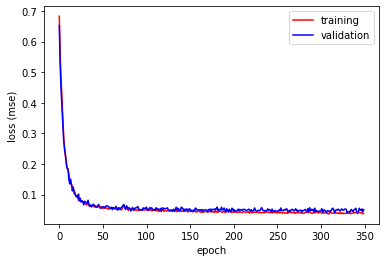

In [ ]:
# plot train and val losses
fig, ax = plt.subplots(1, 1)
ax.plot(training_losses,'red', label = 'training')
ax.plot(validation_losses,'blue', label = 'validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss (mse)')
ax.legend()
plt.savefig(fig_path + 'loss_curve', dpi = 300)

# test the selected model
## compute test loss and also mean angle error

*should pick hyperparameters with lowest validation loss and retrain on combined train and validation sets, then evaluate on the separate test set*

In [ ]:
from scipy.spatial.transform import Rotation as R

# function to compute angular error
def angularError(y, output):
    y = rearrange(y, 'b t (j r c) -> (b t) j r c', j=3,r=3)
    output = rearrange(output, 'b t (j r c) -> (b t) j r c', j=3,r=3)
    
    yDims = y.shape
    sampleSubset = np.arange(0,yDims[0],100)
    angleErrors = np.zeros((len(sampleSubset), yDims[1]))
    for ii, samplei in enumerate(sampleSubset):
        for jointi in range(yDims[1]):

            # get columns of rotation matrices and concatenate them
            y1 = y[samplei,jointi,:,0]
            y2 = y[samplei,jointi,:,1]
            #print(y1,y2)
            y3 =  np.cross(y1,y2)
            yPred1 = output[samplei,jointi,:,0]
            yPred2 = output[samplei,jointi,:,1]
            yPred3 =  np.cross(yPred1,yPred2)

            y_rmat = np.concatenate((y1.reshape(-1,1), y2.reshape(-1,1), y3.reshape(-1,1)),axis=1)
            ypred_rmat = np.concatenate((yPred1.reshape(-1,1), yPred2.reshape(-1,1), yPred3.reshape(-1,1)),axis=1)
            #print(f"m1: {y_rmat} ,M2: {ypred_rmat}")
            # get rotation between target and output
            rot_mat_dif = y_rmat @ ypred_rmat.T
            angleErrors[ii,jointi] = R.from_matrix(rot_mat_dif).magnitude()
            #print(angleErrors[angi])
    return angleErrors

# eval function
def eval_fun(rnn, test_dataset, batch_size, window_size, n_epochs = 1, criterion = nn.MSELoss() ):
    
    # initialize list of losses
    validation_losses = []
    angle_errors = np.empty((0,3))
    
    # dataloaders
    test_dataset.set_windowSize(window_size)
    dataLoader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    # train loop
    #for epoch in range(n_epochs): 
    for epoch in range(n_epochs):     
        # validation phase
        rnn.eval()
        batch_losses = []
        with torch.no_grad():
            for xBatch, yBatch in tqdm(dataLoader_test):
                xBatch = torch.tensor(xBatch).double().to(DEVICE)
                yBatch = torch.tensor(yBatch).double().to(DEVICE)
                output = rnn.forward(xBatch)
                # only consider pose outputs for test loss, throw out acceleration
                loss = criterion(output[:,:,3:], yBatch[:,:,3:])
                angErr = angularError(output[:,:,3:].detach().cpu().numpy(),
                                      yBatch[:,:,3:].detach().cpu().numpy())
                angle_errors = np.append(angle_errors, angErr, axis=0)
                batch_losses.append(loss.detach().cpu().numpy())
            validation_loss = np.mean(batch_losses)
            validation_losses.append(validation_loss)
    return validation_losses, angle_errors

test_losses, angle_errors = eval_fun(rnn, test_dataset, 
                              batch_size = 1, window_size = -1,
                              n_epochs = 1, criterion = nn.MSELoss() )


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 43/43 [01:15<00:00,  1.76s/it]


# plot histogram of mean angular error

mean test loss: 0.03627255409297339
mean angular errors: shoulder: 14.363558169446913 deg, upper arm: 23.41827468487811 deg, hand: 20.229627254006445 deg,


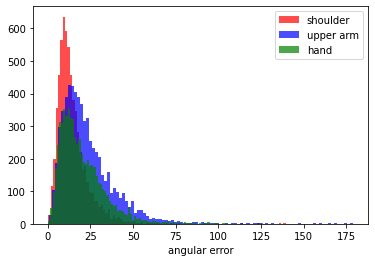

In [ ]:
%matplotlib inline
print(f'mean test loss: {np.mean(test_losses)}')
mean_ang_err = np.mean(angle_errors*180/np.pi,axis=0)
print(f'mean angular errors: shoulder: {np.mean(mean_ang_err[0])} deg, upper arm: {np.mean(mean_ang_err[1])} deg, hand: {np.mean(mean_ang_err[2])} deg,')
fig, ax = plt.subplots(1, 1)
ax.hist(np.array(angle_errors)[:,0]*180/np.pi,bins=100,color='red', alpha = 0.7, label='shoulder')
ax.hist(np.array(angle_errors)[:,1]*180/np.pi,bins=100,color='blue', alpha = 0.7, label='upper arm')
ax.hist(np.array(angle_errors)[:,2]*180/np.pi,bins=100,color='green', alpha = 0.7, label='hand')
ax.set_xlabel('angular error')
ax.legend()
plt.savefig(fig_path + 'angular_error', dpi = 300)
plt.show()

# plot animation

In [ ]:
def get_predictions(rnn, test_dataset, filei):
    test_dataset.set_windowSize(-1)
    dataLoader_test = DataLoader(test_dataset, batch_size=1, shuffle = True)

    ## run model forward
    rnn.eval()
    with torch.no_grad():
        xBatch, yBatch = next(iter(dataLoader_test))
        yPred = rnn.forward(xBatch)
    y = yBatch[0,2000:10000,3:].numpy()
    yP = yPred[0,2000:10000,3:].numpy()
    y = rearrange(y, 't (j r c) -> t j r c', j=3,r=3)
    yP = rearrange(yP, 't (j r c) -> t j r c', j=3,r=3)
    
    # get x
    x = xBatch[0,2000:10000,0:9].numpy()
    x_rot_mats = x.reshape(-1,3,3)


    ## convert 6d orientation to rotation matrices
    yDims = y.shape
    y_rot_mats = np.zeros((yDims[0],yDims[1],3,3))
    yP_rot_mats = np.zeros((yDims[0],yDims[1],3,3))
    for samplei in range(yDims[0]):
        for jointi in range(yDims[1]):
            # get columns of rotation matrices and concatenate them
            y1 = y[samplei,jointi,:,0]
            y2 = y[samplei,jointi,:,1]
            y3 =  np.cross(y1,y2)
            yPred1 = yP[samplei,jointi,:,0]
            yPred2 = yP[samplei,jointi,:,1]
            yPred3 =  np.cross(yPred1,yPred2)

            y_rmat = np.concatenate((y1.reshape(-1,1), y2.reshape(-1,1), y3.reshape(-1,1)),axis=1)
            ypred_rmat = np.concatenate((yPred1.reshape(-1,1), yPred2.reshape(-1,1), yPred3.reshape(-1,1)),axis=1)            
            y_rot_mats[samplei,jointi,:,:] = y_rmat
            yP_rot_mats[samplei,jointi,:,:] = ypred_rmat
            
    return y_rot_mats, yP_rot_mats, x_rot_mats   

y_rot_mats, yP_rot_mats, x_rot_mats = get_predictions(rnn, test_dataset, 13)
print(y_rot_mats.shape, yP_rot_mats.shape)

(8000, 3, 3, 3) (8000, 3, 3, 3)


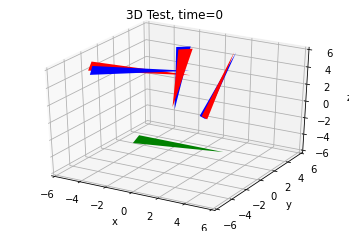

In [ ]:
import matplotlib.animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128


def get_verts(rot,offset):
    verts = np.array([[-0.5,0,0.5],[0,0,0], [-3.5,3.5,-3.5] ])
    verts2 = np.array([[0,0,0],[-0.5,0,0.5], [-3.5,3.5,-3.5] ])

    verts = rot @ verts
    verts2 = rot @ verts2
    
    x = verts[0,:] + offset[0]
    y = verts[1,:]
    z = verts[2,:] + offset[1]

    verts = [list(zip(x,y,z))]
    return verts   

def add_pointer(rot,offset,c):
    verts = get_verts(rot,offset)
    collection = Poly3DCollection(verts,facecolors=c)
    return collection

# make figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i=0

## make collections for y and predicted y triangles

# x values
x1c = add_pointer(x_rot_mats[i,:,:],[0,-4],'g')

# y values
y1c = add_pointer(y_rot_mats[i,0,:,:],[3,4],'r')
y2c = add_pointer(y_rot_mats[i,1,:,:],[0,4],'r')
y3c = add_pointer(y_rot_mats[i,2,:,:],[-3,4],'r')
# predicted y values
y1Pc = add_pointer(yP_rot_mats[i,0,:,:],[3,4],'b')
y2Pc = add_pointer(yP_rot_mats[i,1,:,:],[0,4],'b')
y3Pc = add_pointer(yP_rot_mats[i,2,:,:],[-3,4],'b')
# add collections
ax.add_collection(x1c)
ax.add_collection(y1c)
ax.add_collection(y2c)
ax.add_collection(y3c)
ax.add_collection(y1Pc)
ax.add_collection(y2Pc)
ax.add_collection(y3Pc)

# configure figure
#title.set_text('3D Test, time={}'.format(i))
ax.set_xlim3d(-6, 6)
ax.set_ylim3d(-6, 6)
ax.set_zlim3d(-6, 6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
title = ax.set_title('3D Test')

def update_graph(i):
    # x values
    x1c.set_verts(get_verts(x_rot_mats[i,:,:],[0,-4]))
    # true y values
    y1c.set_verts(get_verts(y_rot_mats[i,0,:,:],[3,4]))
    y2c.set_verts(get_verts(y_rot_mats[i,1,:,:],[0,4]))
    y3c.set_verts(get_verts(y_rot_mats[i,2,:,:],[-3,4]))
    # predicted y
    y1Pc.set_verts(get_verts(yP_rot_mats[i,0,:,:],[3,4]))
    y2Pc.set_verts(get_verts(yP_rot_mats[i,1,:,:],[0,4]))
    y3Pc.set_verts(get_verts(yP_rot_mats[i,2,:,:],[-3,4]))

    title.set_text('3D Test, time={}'.format(i))

ani = matplotlib.animation.FuncAnimation(fig, update_graph, np.arange(0,8000,5),interval=62)
writergif = matplotlib.animation.PillowWriter(fps=30) 
ani.save(fig_path + 'animation_wide.gif', writer=writergif)
ani



# scratch code...

In [ ]:
def get_orthonormal_rot(rotMat):
    # model predicts each element of the rotation matrix as separate output dimensions
    # rotation matrix shoudl be orthonormal, but we do not enforce this constraint
    # here just take 2 columns and determine the third 
    v1 = rotMat[:,0]
    v2 = rotMat[:,1]
    c1 = v1 / np.linalg.norm(v1)
    u2 = v2 - np.dot(c1,v2)*c1
    c2 = u2 /  np.linalg.norm(u2)
    c3 = np.cross(c1,c2)
    return np.concatenate((c1.reshape(-1,1),c2.reshape(-1,1),c3.reshape(-1,1)),axis = 1)
#get_orthonormal_rot(rotMat)